# DeepTCN Model For TimeSeries Forecasting Univariate series (co2)

https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_10_5_keras_transformers.ipynb

https://keras.io/examples/timeseries/

# Libraries

In [1]:
#!pip install optuna

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import optuna
import matplotlib.pyplot as plt
import os
from keras.models import load_model
#%tensorflow_version 2.x

ModuleNotFoundError: No module named 'optuna'

# Data

In [3]:
df = pd.read_csv('DataSets /WORLD-OWID-Features-Yearly')
df.set_index('year', inplace=True)
df.tail(5)


,cement_co2,co2,coal_co2,flaring_co2,gas_co2,land_use_change_co2,oil_co2,other_industry_co2
year,,,,,,,,
2017-01-01,1507.923,36096.7380,14506.974,391.992,7144.928,4331.947,12242.628,302.294
2018-01-01,1569.218,36826.5080,14746.831,412.116,7529.847,4181.356,12266.017,302.479
2019-01-01,1617.507,37082.5590,14725.978,439.254,7647.528,4557.283,12345.653,306.639
2020-01-01,1637.537,37103.2055,14174.564,407.584,7556.290,4057.758,11191.809,296.302
2021-01-01,1672.592,37123.8520,14979.598,416.526,7921.830,3939.044,11837.159,296.146


As we can see tha value of 2020 is an outlier compared to the other years because of corona... We will change this value with the mean of 2019 and 2021 combined. This way our future predictions/foreastings will be more accurate. 

In [4]:
#mean_co2 = df.loc[[2019, 2021], 'co2'].mean()
#df.loc[2020, 'co2'] = mean_co2

#df.tail(3)

   ##   Already done when converting Yearly to Monthly   !!!  

# Defining our train, test & val set

In [5]:
train_set = df[(df.index <= '2000-01-01')]
test_set = df[(df.index > '2000-01-01') & (df.index <= '2011-01-01')]
validate_set = df[df.index > '2011-01-01']

print("Train set:")
print(train_set.index.min(), "to", train_set.index.max())

print("Test set:")
print(test_set.index.min(), "to", test_set.index.max())

print("Validation set:")
print(validate_set.index.min(), "to", validate_set.index.max())

Train set:
1880-01-01 to 2000-01-01
Test set:
2001-01-01 to 2011-01-01
Validation set:
2012-01-01 to 2021-01-01


In [6]:
train_data = train_set['co2'].tolist()
test_data = test_set['co2'].tolist()
val_data = validate_set['co2'].tolist()

# defining our Window/LookBack length





In [7]:
def to_sequences(seq_size, obs):

  x = []
  y = []

  for i in range(len(obs)-SEQUENCE_SIZE):
    #print(i)
    window = obs[i:(i+SEQUENCE_SIZE)]
    after_window = obs[i+SEQUENCE_SIZE]
    window = [[x] for x in window]
    #print("{} - {}".format(window,after_window))
    x.append(window)
    y.append(after_window)

  return np.array(x),np.array(y)

SEQUENCE_SIZE = 5
x_train,y_train = to_sequences(SEQUENCE_SIZE, train_data)
x_test,y_test = to_sequences(SEQUENCE_SIZE, test_data)
x_val, y_val = to_sequences(SEQUENCE_SIZE, val_data)

print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))
print("Shape of val set: {}".format(x_val.shape))

Shape of training set: (116, 5, 1)
Shape of test set: (6, 5, 1)
Shape of val set: (5, 5, 1)


# Scaling Data

In [8]:
'''train_data = np.log(train_data)
test_data = np.log(test_data)
val_data = np.log(val_data)'''

'train_data = np.log(train_data)\ntest_data = np.log(test_data)\nval_data = np.log(val_data)'

In [9]:
'''from sklearn.preprocessing import StandardScaler

# Maak een scaler voor de kenmerken (X)
feature_scaler = StandardScaler()
X_train_scaled = feature_scaler.fit_transform(x_train)
X_test_scaled = feature_scaler.transform(x_test)
X_val_scaled = feature_scaler.transform(x_val)

# Maak een scaler voor de doelvariabelen (y)
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)
y_val_scaled = target_scaler.transform(y_val)'''


'from sklearn.preprocessing import StandardScaler\n\n# Maak een scaler voor de kenmerken (X)\nfeature_scaler = StandardScaler()\nX_train_scaled = feature_scaler.fit_transform(x_train)\nX_test_scaled = feature_scaler.transform(x_test)\nX_val_scaled = feature_scaler.transform(x_val)\n\n# Maak een scaler voor de doelvariabelen (y)\ntarget_scaler = StandardScaler()\ny_train_scaled = target_scaler.fit_transform(y_train)\ny_test_scaled = target_scaler.transform(y_test)\ny_val_scaled = target_scaler.transform(y_val)'

# Metrics Helper Function

In [10]:
def print_metrics(pred, y_test, model_name):
    mae_ = mean_absolute_error(pred, y_test)
    rmse_ = np.sqrt(mean_squared_error(pred, y_test))
    mape_ = mean_absolute_percentage_error(pred, y_test)
    r2_score_ = r2_score(pred, y_test)

    dict_ = {
        'MAE': mae_,
        'RMSE': rmse_,
        'MAPE': mape_,
        'R2': r2_score_
    }

    metrics = pd.DataFrame(dict_, index=[model_name])

    return metrics.round(decimals=2)

# Building the DeepTCN Model

In [44]:
# Convert data to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)  # Reshape target
x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)  # Reshape target
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [25]:
class DeepTCN(nn.Module):
    def __init__(self, input_size, output_size, num_layers, num_filters, kernel_size, dropout_rate):
        super(DeepTCN, self).__init__()

        self.input_size = input_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.num_filters = num_filters
        self.kernel_size = kernel_size
        self.dropout_rate = dropout_rate
        
        self.conv_layers = nn.ModuleList([
            nn.Conv1d(in_channels=1 if i == 0 else num_filters,
                      out_channels=num_filters,
                      kernel_size=kernel_size,
                      padding=kernel_size // 2) for i in range(num_layers)
        ])
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(num_filters, output_size)
        
    def forward(self, x):
        # Input shape: (batch_size, sequence_length, input_size)
        batch_size, sequence_length, _ = x.size()
        
        # Reshape input for 1D convolution: (batch_size, input_size, sequence_length)
        x = x.permute(0, 2, 1)
        
        # Apply convolutional layers
        for conv_layer in self.conv_layers:
            x = conv_layer(x)
            x = self.relu(x)
            x = self.dropout(x)
        
        # Global average pooling: (batch_size, num_filters)
        x = nn.functional.adaptive_avg_pool1d(x, output_size=1)
        x = x.view(batch_size, self.num_filters)
        
        # Fully connected layer
        output = self.linear(x)
        
        return output

In [40]:
def objective(trial):
    # Define hyperparameters to tune
    input_size = trial.suggest_int("input_size", 32, 128)
    num_layers = trial.suggest_int("num_layers", 1, 4)
    num_filters = trial.suggest_int("num_filters", 16, 64)
    kernel_size = trial.suggest_int("kernel_size", 3, 7)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    num_epochs = trial.suggest_int("num_epochs", 10, 50)  # Add epochs as a hyperparameter

    # Create and train the model with the suggested hyperparameters
    model = DeepTCN(input_size, output_size, num_layers, num_filters, kernel_size, dropout_rate)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = torch.nn.L1Loss()

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        outputs = model(x_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()

    # Calculate validation loss (or any other metric you want to optimize)
    model.eval()
    val_outputs = model(x_val_tensor)
    val_loss = criterion(val_outputs, y_val_tensor)

    return val_loss.item()

In [41]:
study = optuna.create_study(direction="minimize")

# Run optimization
study.optimize(objective, n_trials=10)

[I 2023-08-26 23:47:45,254] A new study created in memory with name: no-name-1a387ba6-f604-41cb-906a-933147d90503
[I 2023-08-26 23:47:45,646] Trial 0 finished with value: 11154.0576171875 and parameters: {'input_size': 89, 'num_layers': 4, 'num_filters': 55, 'kernel_size': 5, 'dropout_rate': 0.22752331956247238, 'num_epochs': 10}. Best is trial 0 with value: 11154.0576171875.
[I 2023-08-26 23:47:46,723] Trial 1 finished with value: 1554.2945556640625 and parameters: {'input_size': 43, 'num_layers': 4, 'num_filters': 49, 'kernel_size': 4, 'dropout_rate': 0.39161377073356884, 'num_epochs': 28}. Best is trial 1 with value: 1554.2945556640625.
[I 2023-08-26 23:47:48,146] Trial 2 finished with value: 1440.596923828125 and parameters: {'input_size': 123, 'num_layers': 4, 'num_filters': 56, 'kernel_size': 7, 'dropout_rate': 0.4989790790704912, 'num_epochs': 33}. Best is trial 2 with value: 1440.596923828125.
[I 2023-08-26 23:47:49,184] Trial 3 finished with value: 1097.28515625 and parameters

In [42]:
best_params = study.best_params
best_value = study.best_value

print("Best Parameters:", best_params)
print("Best Value (MAE):", best_value)

Best Parameters: {'input_size': 127, 'num_layers': 4, 'num_filters': 62, 'kernel_size': 4, 'dropout_rate': 0.1849448681576527, 'num_epochs': 48}
Best Value (MAE): 351.6195373535156


In [45]:
# Extract the best hyperparameters
best_input_size = best_params["input_size"]
best_num_layers = best_params["num_layers"]
best_num_filters = best_params["num_filters"]
best_kernel_size = best_params["kernel_size"]
best_dropout_rate = best_params["dropout_rate"]
best_num_epochs = best_params["num_epochs"]

# Create the model using the best hyperparameters
best_model = DeepTCN(best_input_size, output_size, best_num_layers, best_num_filters, best_kernel_size, best_dropout_rate)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(best_model.parameters(), lr=0.001)
criterion = torch.nn.L1Loss()

# Training loop
for epoch in range(best_num_epochs):
    best_model.train()
    optimizer.zero_grad()
    outputs = best_model(x_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    # Print training progress
    print(f"Epoch [{epoch+1}/{best_num_epochs}], Loss: {loss.item():.4f}")

# After training, you can use the best_model to make predictions and evaluate on the test set
best_model.eval()
test_outputs = best_model(x_test_tensor)

# Calculate and print metrics using the print_metrics function
test_metrics = print_metrics(test_outputs.detach().numpy(), y_test_tensor.detach().numpy(), "Test Metrics")
print(test_metrics)

Epoch [1/48], Loss: 8855.8848
Epoch [2/48], Loss: 8559.1123
Epoch [3/48], Loss: 8179.4326
Epoch [4/48], Loss: 7664.7061
Epoch [5/48], Loss: 6936.8721
Epoch [6/48], Loss: 5895.2100
Epoch [7/48], Loss: 4500.8936
Epoch [8/48], Loss: 2528.9585
Epoch [9/48], Loss: 692.4605
Epoch [10/48], Loss: 3263.7192
Epoch [11/48], Loss: 3862.1802
Epoch [12/48], Loss: 2799.7568
Epoch [13/48], Loss: 1741.1038
Epoch [14/48], Loss: 735.2114
Epoch [15/48], Loss: 1526.2125
Epoch [16/48], Loss: 2060.6697
Epoch [17/48], Loss: 2246.4697
Epoch [18/48], Loss: 2256.2422
Epoch [19/48], Loss: 1760.8329
Epoch [20/48], Loss: 1199.2906
Epoch [21/48], Loss: 790.4301
Epoch [22/48], Loss: 874.0776
Epoch [23/48], Loss: 1362.5426
Epoch [24/48], Loss: 1537.7672
Epoch [25/48], Loss: 1363.9313
Epoch [26/48], Loss: 880.7621
Epoch [27/48], Loss: 853.4594
Epoch [28/48], Loss: 996.8088
Epoch [29/48], Loss: 1190.8425
Epoch [30/48], Loss: 1122.2355
Epoch [31/48], Loss: 1021.5912
Epoch [32/48], Loss: 759.0006
Epoch [33/48], Loss: 631.

In [46]:
# Evaluate the best_model on the validation set
best_model.eval()
val_outputs = best_model(x_val_tensor)

# Calculate and print metrics using the print_metrics function for validation set
val_metrics = print_metrics(val_outputs.detach().numpy(), y_val_tensor.detach().numpy(), "Validation Metrics")
print(val_metrics)

                            MAE    RMSE  MAPE    R2
Validation Metrics  1134.160034  1166.0  0.03 -6.44


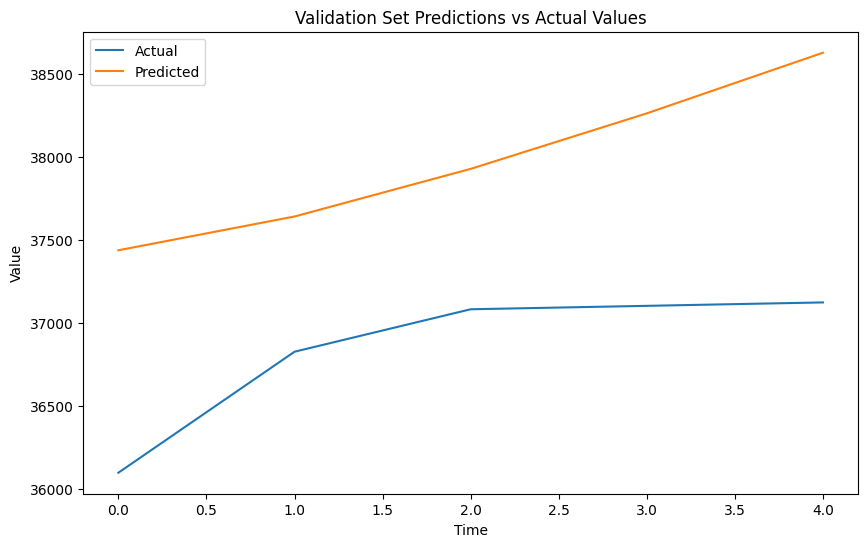

In [49]:
# Convert the validation set predictions and actual values to NumPy arrays
val_preds = val_outputs.detach().numpy()
val_actual = y_val_tensor.detach().numpy()

# Plot the predictions and actual values
plt.figure(figsize=(10, 6))
plt.plot(val_actual, label='Actual')
plt.plot(val_preds, label='Predicted')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Validation Set Predictions vs Actual Values')
plt.legend()
plt.show()

In [51]:
# Get the time index for the validation set
val_time_index = validate_set.index[SEQUENCE_SIZE:]

# Create a DataFrame to display the actual values and predictions
val_comparison_df = pd.DataFrame({
    'Time': val_time_index,
    'Actual': val_actual.flatten(),
    'Predicted': val_preds.flatten()
})

# Print the DataFrame
print(val_comparison_df)

         Time        Actual     Predicted
0  2017-01-01  36096.738281  37438.398438
1  2018-01-01  36826.507812  37642.078125
2  2019-01-01  37082.558594  37929.234375
3  2020-01-01  37103.207031  38264.164062
4  2021-01-01  37123.851562  38629.796875


In [ ]:
def objective(trial):

  input_shape = x_train.shape[1:]

  head_size = trial.suggest_int("head_size", 64, 184)
  num_heads = trial.suggest_int("num_heads", 2, 8)
  ff_dim = trial.suggest_int("ff_dim", 6, 12)
  num_transformer_blocks = trial.suggest_int("num_transformer_blocks", 3, 7)
  mlp_units = [trial.suggest_int("mlp_units", 32, 96)]
  mlp_dropout = trial.suggest_float("mlp_dropout", 0.25, 0.35)
  dropout = trial.suggest_float("dropout", 0.25, 0.35)
  learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2)
  n_epochs = trial.suggest_int("n_epochs", 8, 64)
  #batch_size = trial.suggest_int("batch_size", 16, 128, step=16)

  model = build_model(
      input_shape,
      head_size=head_size,
      num_heads=num_heads,
      ff_dim=ff_dim,
      num_transformer_blocks=num_transformer_blocks,
      mlp_units=mlp_units,
      mlp_dropout=mlp_dropout,
      dropout=dropout,
  )

  model.compile(
      loss="mean_absolute_error",
      optimizer=keras.optimizers.legacy.Adam(learning_rate=learning_rate)
  )
  model.summary()

  callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

  model.fit(
      x_train,
      y_train,
      validation_split=0.2,
      epochs=n_epochs,
      batch_size=64,
      callbacks=callbacks,
  )

  loss = model.evaluate(x_test, y_test, verbose=1)
  return loss

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Viewing our Trials

In [ ]:
all_trials = study.trials

trial_results = []

for trial in all_trials:
    trial_params = trial.params
    trial_value = trial.value
    trial_result = {**trial_params, "value": trial_value}
    trial_results.append(trial_result)

trial_results_df = pd.DataFrame(trial_results)

print(trial_results_df)

# Retrieving the best parameters from our search and building our model with these

In [ ]:
best_params = study.best_params
best_loss = study.best_value
print(f"Best parameters: {best_params}")
print(f"Best loss: {best_loss}")

In [ ]:
best_model = build_model(
    input_shape=x_train.shape[1:],
    head_size=best_params["head_size"],
    num_heads=best_params["num_heads"],
    ff_dim=best_params["ff_dim"],
    num_transformer_blocks=best_params["num_transformer_blocks"],
    mlp_units=[best_params["mlp_units"]],
    mlp_dropout=best_params["mlp_dropout"],
    dropout=best_params["dropout"],
)

In [ ]:
best_model.compile(
    loss="mean_absolute_error",
    optimizer=keras.optimizers.legacy.Adam(learning_rate=best_params['learning_rate'])
)

In [ ]:
callbacks = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

best_model.fit(
    x_train,
    y_train,
    epochs=best_params['n_epochs'],
    batch_size=128,
    validation_split=0.2,
    verbose=1,
    callbacks=callbacks
)

# Saving the model and its weights for future usage 

In [ ]:
save_weights_at = os.path.join(
    'Transformers_Best_Models_and_weights',
    f'best_model_weightss_{best_loss:.4f}.hdf5'
)

best_model.save(save_weights_at)

# Accessing the saved model of choice 

In [ ]:

saved_model_path = 'Transformers_Best_Models_and_weights/best_model_weights_350_val.hdf5'
saved_model = load_model(saved_model_path)

# Forecasting Validation on the test set

In [ ]:
pred = saved_model.predict(x_test)

print_metrics(pred, y_test, 'Transformer_Scores')

In [ ]:
pred_flat = pred.flatten()
y_test_flat = y_test.flatten()

# Create a DataFrame to compare predictions and actual values
result_df = pd.DataFrame({'Prediction': pred_flat, 'Actual': y_test_flat})

result_df.index = test_set.index[-6:]

print(result_df)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, result_df['Prediction'], label='Prediction')
plt.plot(result_df.index, result_df['Actual'], label='Actual')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

# Forecasting Validation on the val set

In [ ]:
pred_val = saved_model.predict(x_val)

print_metrics(pred_val, y_val, 'Transformer_Scores')

In [ ]:
pred_val_flat = pred_val.flatten()
y_val_flat = y_val.flatten()

# Create a DataFrame to compare predictions and actual values
result_df_val = pd.DataFrame({'Prediction': pred_val_flat, 'Actual': y_val_flat})

result_df_val.index = validate_set.index[-5:]

print(result_df_val)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(result_df_val.index, result_df_val['Prediction'], label='Prediction')
plt.plot(result_df_val.index, result_df_val['Actual'], label='Actual')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Ensembling of the 2 Best Models 

In [ ]:
model_a = load_model('Transformers_Best_Models_and_weights/best_model_weights_89.2867.hdf5')
model_b = load_model('Transformers_Best_Models_and_weights/best_model_weightss_89_R2_0.98.hdf5')

In [ ]:
pred_a = model_a.predict(x_test)
pred_b = model_b.predict(x_test)

In [ ]:
val_pred_a = model_a.predict(x_val)
val_pred_b = model_b.predict(x_val)

In [ ]:
weight_model_a = 0.6
weight_model_b = 0.4

In [ ]:
ensemble_pred = (weight_model_a * pred_a) + (weight_model_b * pred_b)

ensemble_pred_val = ((weight_model_a * val_pred_a) + (weight_model_b * val_pred_b))

# Forecasting using the Ensembled Models

In [ ]:
print_metrics(ensemble_pred, y_test, 'Transformer_Ensembled_Scores_TEST')

In [ ]:
print_metrics(ensemble_pred_val, y_val, 'Transformer_Ensembled_Scores_val')

In [ ]:
pred_ensembled_flat = ensemble_pred.flatten()
y_test_flat = y_test.flatten()

# Create a DataFrame to compare predictions and actual values
ensembled_result_df = pd.DataFrame({'Prediction': pred_ensembled_flat, 'Actual': y_test_flat})

ensembled_result_df.index = test_set.index[-127:]

print("TEST Set:")
print("\n")
print(ensembled_result_df)

pred_ensembled_val_flat = ensemble_pred_val.flatten()
y_val_flat = y_val.flatten()

# Create a DataFrame to compare predictions and actual values
ensembled_result_val_df = pd.DataFrame({'Prediction': pred_ensembled_val_flat, 'Actual': y_val_flat})

ensembled_result_val_df.index = validate_set.index[-115:]

print("\n")
print("VAL Set:")
print("\n")
print(ensembled_result_val_df)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(result_df.index, ensembled_result_df['Prediction'], label='Prediction')
plt.plot(result_df.index, ensembled_result_df['Actual'], label='Actual')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Test Set: Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(result_df_val.index, ensembled_result_val_df['Prediction'], label='Prediction')
plt.plot(result_df_val.index, ensembled_result_val_df['Actual'], label='Actual')
plt.xlabel('Year')
plt.ylabel('Value')
plt.title('Val set: Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

# Forecasting Future Values 2021-02-01 until 2024-01-01

**Creating our dataframe** 

In [ ]:
forecast_start_date = pd.Timestamp("2021-02-01")  
forecast_end_date = pd.Timestamp("2024-01-01")    
forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date, freq='MS')


forecast_df = pd.DataFrame(index=forecast_index)

#print(forecast_df)

**Forecasting our Values + gaining insights into the input-output process**

In [ ]:
initial_sequence = x_val[-5]
forecast_horizon = 36

dates = []
predicted_values = []

for year in range(forecast_horizon):
    # Predict the next value using the trained model
    predicted_value = saved_model.predict(np.expand_dims(initial_sequence, axis=0))

    predicted_values.append(predicted_value)
    
    print(f"Year: {year + 1}")
    print(f"Initial Sequence: {initial_sequence}")
    print(f"Predicted Value: {predicted_value}")
    
    # Updating the initial sequence for the next prediction
    initial_sequence = np.concatenate([initial_sequence[1:], predicted_value], axis=0)

predicted_values_array = np.array(predicted_values).squeeze()

# Add the forecasted values as a new column to the DataFrame
forecast_df["Forecasted_Value"] = predicted_values_array

print(forecast_df)

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast_df["Forecasted_Value"], label="Forecasted Values")
plt.xlabel("Date")
plt.ylabel("Forecasted Value")
plt.title("Forecasted Values from 2022 to 2030")
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()